<a href="https://colab.research.google.com/github/sennycho/cat_and_dog/blob/main/%EA%B0%95%EC%95%84%EC%A7%80_%EA%B3%A0%EC%96%91%EC%9D%B4_%EB%B6%84%EB%A5%98%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'sennycho'  # username
os.environ['KAGGLE_KEY'] = 'c2f8e1539d07ee66f4c21e31db80e074'  # key

In [ ]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip -q cat-and-dog.zip

 99% 216M/218M [00:10<00:00, 22.9MB/s]
100% 218M/218M [00:10<00:00, 20.8MB/s]


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
data_transforms ={
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomAffine(0, shear=10 , scale =(0.8,1.2)),
        transforms.RandomHorizontalFlip(), # 좌우반전
        transforms.ToTensor(),
    ]),
    'validation':transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

In [ ]:
def target_transforms(target):
    return torch.FloatTensor([target])

In [ ]:
# ImageFolder(): 함수쓴
image_datasets = {
    'train': datasets.ImageFolder('training_set/training_set', data_transforms['train'], target_transform=target_transforms),
    'validation': datasets.ImageFolder('test_set/test_set', data_transforms['validation'], target_transform=target_transforms)
}

dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

print(len(image_datasets['train']), len(image_datasets['validation']))

8005 2023


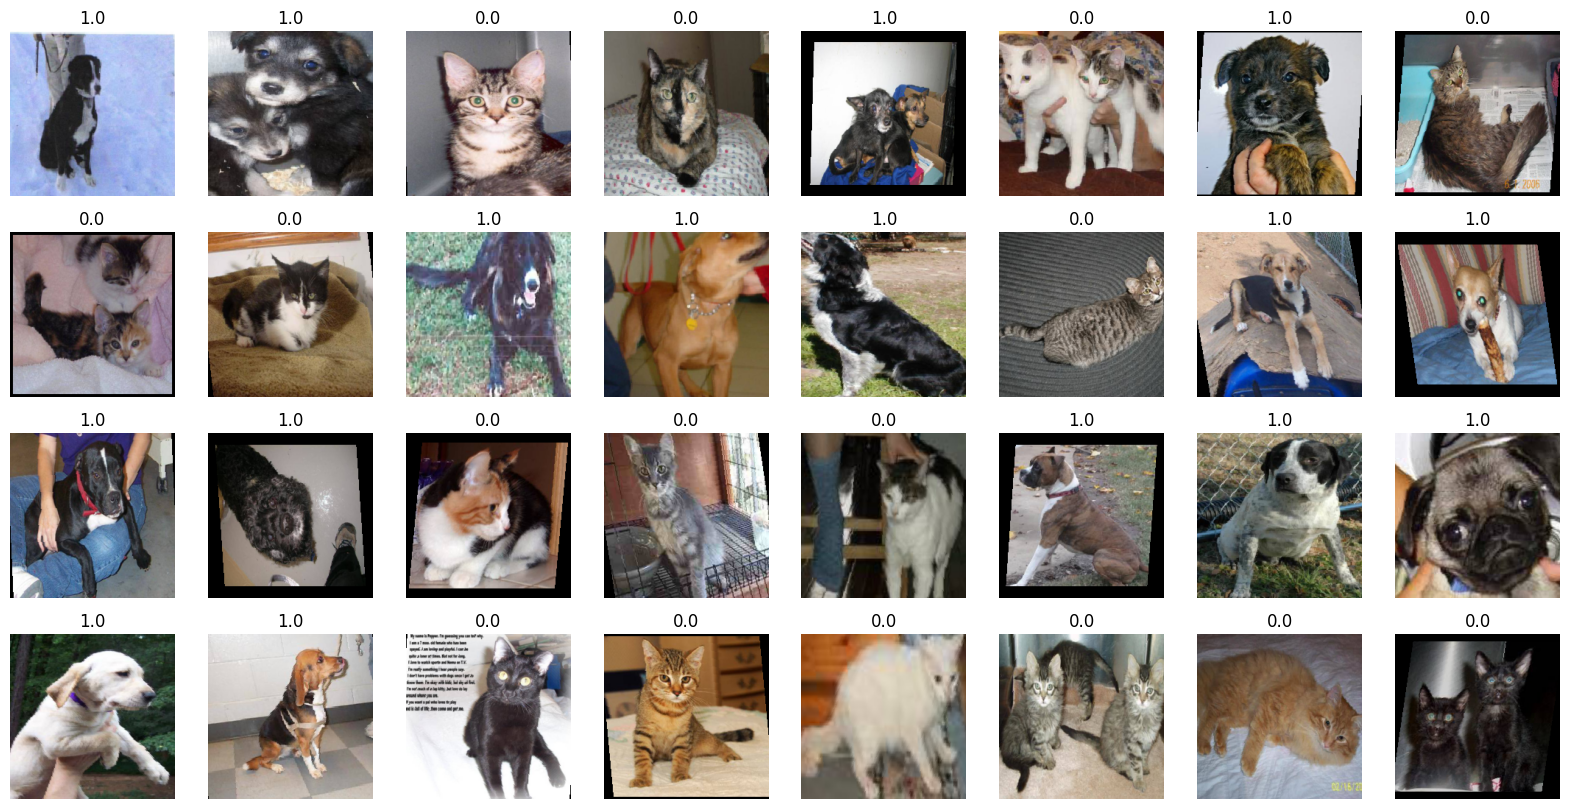

In [ ]:
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for img, label, ax in zip(imgs, labels, axes.flatten()):
    ax.set_title(label.item())
    ax.imshow(img.permute(1, 2, 0))    # permute(): 주어진 리스트의 원소를 모든 가능한 순열로 재배열하는 함수.
    ax.axis('off')

In [13]:
# model = models.resnet50(pretrained=True).to(device)   => 미리 학습된것을 쓰겠다는 뜻
model = models.resnet50(weights='IMAGENET1K_V1').to(device)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 97.8MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
for param in model.parameters():
    param.requires_grad = False  # 가져온 파라미터(W, b)를 업데이트하지 않음

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
# 학습: fc부분만 학습하므로 속도가 빠름
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
epochs = 10
for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()      # eval()하면 모델이 검증모드 된다
        sum_losses = 0
        sum_accs = 0
        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_pred = model(x_batch)
            loss = nn.BCELoss()(y_pred, y_batch)
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            sum_losses = sum_losses + loss.item()
            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc.item()
        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')


train     : Epoch    1/10, Loss: 0.1189, Accuracy: 95.36%
validation: Epoch    1/10, Loss: 0.0507, Accuracy: 98.00%
train     : Epoch    2/10, Loss: 0.0972, Accuracy: 96.16%
validation: Epoch    2/10, Loss: 0.0805, Accuracy: 96.83%
train     : Epoch    3/10, Loss: 0.0842, Accuracy: 96.81%
validation: Epoch    3/10, Loss: 0.0481, Accuracy: 98.34%
train     : Epoch    4/10, Loss: 0.0802, Accuracy: 96.71%
validation: Epoch    4/10, Loss: 0.0399, Accuracy: 98.58%
train     : Epoch    5/10, Loss: 0.0780, Accuracy: 96.78%
validation: Epoch    5/10, Loss: 0.0500, Accuracy: 98.10%
train     : Epoch    6/10, Loss: 0.0689, Accuracy: 97.26%
validation: Epoch    6/10, Loss: 0.0432, Accuracy: 98.58%
train     : Epoch    7/10, Loss: 0.0747, Accuracy: 97.01%
validation: Epoch    7/10, Loss: 0.0679, Accuracy: 97.22%
train     : Epoch    8/10, Loss: 0.0799, Accuracy: 96.88%
validation: Epoch    8/10, Loss: 0.0386, Accuracy: 98.93%
train     : Epoch    9/10, Loss: 0.0630, Accuracy: 97.50%
validation: Ep

In [16]:
torch.save(model.state_dict(), 'model.h5')

model = models.resnet50().to(device)

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)

In [18]:
# 모델 로드
model.load_state_dict(torch.load('model.h5'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

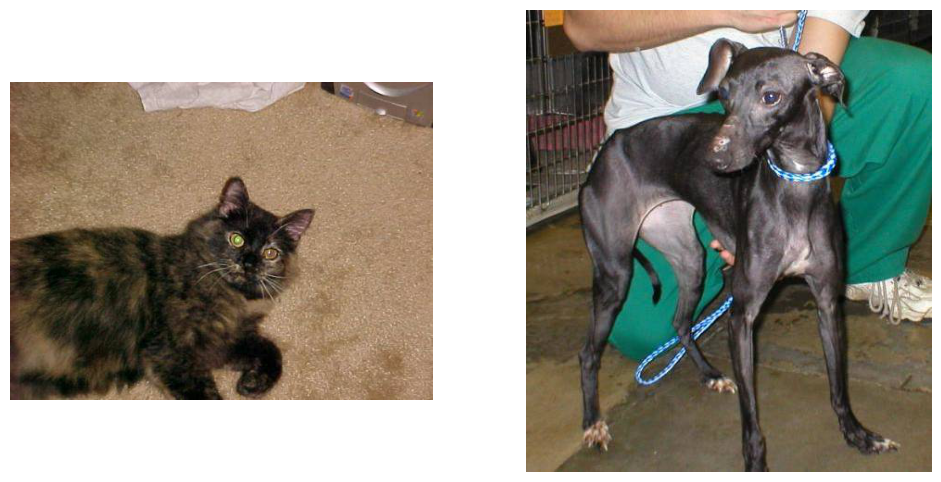

In [33]:
# 테스트
from PIL import Image

img1 = Image.open('test_set/test_set/cats/cat.4004.jpg')
img2 = Image.open('test_set/test_set/dogs/dog.4004.jpg')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [34]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)
print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [35]:
test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)
test_batch.shape

torch.Size([2, 3, 224, 224])

In [36]:
y_pred = model(test_batch)
y_pred

tensor([[1.0406e-04],
        [9.9979e-01]], device='cuda:0', grad_fn=<SigmoidBackward0>)

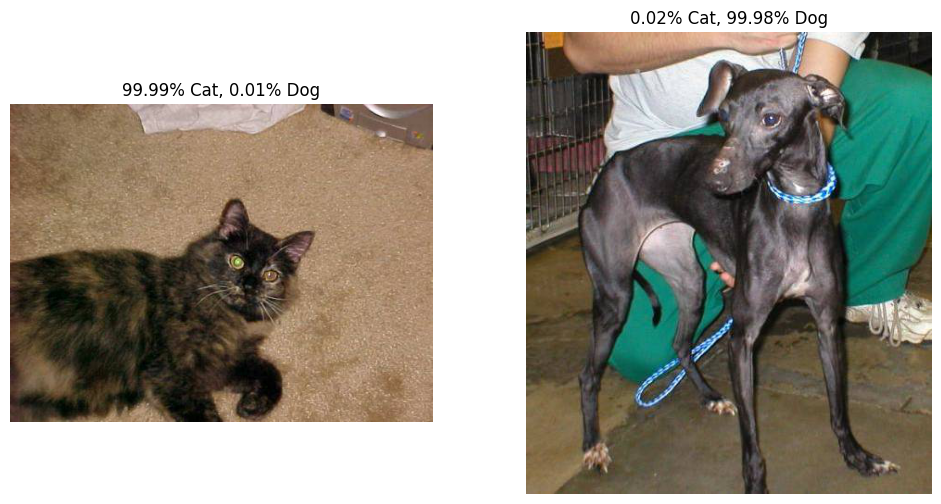

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title(f'{(1-y_pred[0, 0]) * 100:.2f}% Cat, {y_pred[0, 0] * 100:.2f}% Dog')
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].set_title(f'{(1-y_pred[1, 0]) * 100:.2f}% Cat, {y_pred[1, 0] * 100:.2f}% Dog')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()